## Libraries Required

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sms

%matplotlib inline

### Connection to the Northwind SQL Database

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

### Looking at the Tables
The first thing we do is take a look at the tables present in the Northwind SQL DB to ensure all the data we expect to be there is there.

In [3]:
cur.execute("""
    Select name from sqlite_master
    Where type is "table"
""")
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

All of the tables we expect from our ERD are present.

## Experiment 1: Discounts
The first experiment we're running is to see whether discounting an order impacts the quantity of an item ordered.

**Null Hypothesis: Discount has no impact on the quantity of an order**

**Alternate Hypothesis: Discount has an impact on the quantity of an order**

### Collecting the Appropriate Data
In order to get the appropriate data for our experiment. We fist create a SQL query that gathers each order, each product was in that order, and how much of each product was in that order. We then save them to two separate DataFrames; one for no discount orders and one for discounted orders.

### No Discount DataFrame

In [4]:
cur.execute("""
    Select OrderId, ProductId, Quantity, Discount from OrderDetail
    Where Discount = 0
""")
no_disc_df = pd.DataFrame(cur.fetchall())
no_disc_df.columns = [x[0] for x in cur.description]
no_disc_df.head()

,OrderId,ProductId,Quantity,Discount
0,10248,11,12,0.0
1,10248,42,10,0.0
2,10248,72,5,0.0
3,10249,14,9,0.0
4,10249,51,40,0.0


### Discounted DataFrame

In [5]:
cur.execute("""
    Select OrderId, ProductId, Quantity, Discount from OrderDetail
    Where Discount IS NOT 0
""")
disc_df = pd.DataFrame(cur.fetchall())
disc_df.columns = [x[0] for x in cur.description]
disc_df.head()

,OrderId,ProductId,Quantity,Discount
0,10250,51,35,0.15
1,10250,65,15,0.15
2,10251,22,6,0.05
3,10251,57,15,0.05
4,10252,20,40,0.05


### Distribution Plots for the Quantities of Discounted and No Discount Orders
We first look at the distributions to see if there are concerns about the data being normally distributed.

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


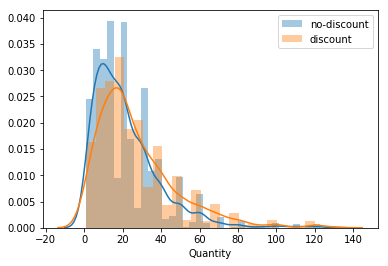

In [6]:
a = no_disc_df['Quantity']
b = disc_df['Quantity']
sns.distplot(a, label='no-discount')
sns.distplot(b, label='discount')
plt.legend()

### Hypothesis Test Statistics
Since there are concerns about the data being normally distributed, we will run both a 2-sample t-test and a Mann-Whitney test to test for the significance of a discount on the order. We will also run a Kolmogrov-Smirnov 2-sample test to validate the normality of the data.

In [7]:
stats.ttest_ind(a,b)

Ttest_indResult(statistic=-6.4785631962949015, pvalue=1.1440924523215966e-10)

In [8]:
stats.ks_2samp(a,b)

Ks_2sampResult(statistic=0.12135050550629461, pvalue=4.763897379538179e-07)

In [9]:
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=461541.0, pvalue=6.629381826999866e-11)

We can see from the results that both the Mann-Whitney and t-test both have p-values below the alpha of .05. Therefore, we can reject the null hypothesis and say that discount does have an impact on quantity ordered.

### Effect Size
The next step after we have concluded that discounts are statistically significant is to then measure the effect size it has on the quantity ordered. We do this by using Cohen's D. We first use a function to define finding Cohen D and then calculating it for our samples.

In [10]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [11]:
abs(Cohen_d(a,b))

0.2862724481729282

Our Cohen D in this case is relatively small indicating that the effect size of discount on quantity ordered is small.

In [157]:
cur.execute("""
    Select OrderId, ProductId, Quantity, Discount from OrderDetail
""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,OrderId,ProductId,Quantity,Discount
0,10248,11,12,0.0
1,10248,42,10,0.0
2,10248,72,5,0.0
3,10249,14,9,0.0
4,10249,51,40,0.0


## Experiment 2: Regions
The second experiment is to determine if the region a customer is from impacts the quantities in their orders.

**Null Hypothesis: Region has no impact on quantities in an order**

**Alternate Hypothesis: Region has an impact on quantities in an order**

### Collecting Our Data
The first step is to write a SQL query that shows how much of a product certain regions buy.

In [17]:
cur.execute("""
    Select Customer.Region as BuyerRegion, ProductID, Sum(Quantity) as Quantity from Employee
    Join [Order]
    ON [Order].EmployeeID = Employee.ID
    Join OrderDetail
    ON [Order].ID = OrderDetail.OrderID
    JOIN Customer
    ON [Order].CustomerID = Customer.ID
    Group BY BuyerRegion, ProductID
""")
region_df = pd.DataFrame(cur.fetchall())
region_df.columns = [x[0] for x in cur.description]
region_df.head()

,BuyerRegion,ProductId,Quantity
0,British Isles,1,88
1,British Isles,2,82
2,British Isles,3,30
3,British Isles,4,45
4,British Isles,5,60


### Distribution Plot
The next step is to plot these quantities on a distribution plot to see if there are concerns about the data being normaly distributed.

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


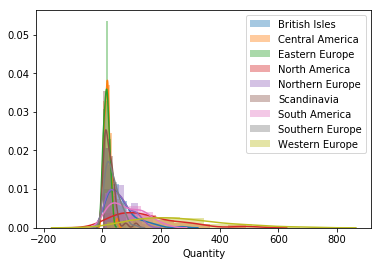

In [18]:
for region in region_df['BuyerRegion'].unique():
    sns.distplot(region_df['Quantity'][region_df['BuyerRegion'] == region], label=region)
    plt.legend()

Our results shows there are some concerns about normality.

### Hypothesis Tests
The first thing we will do is confirm whether the data is normally distributed using the Kolmogrov-Smirnov Test. This will help us determine whether to run a one-sided ANOVA or a Kruskal-Wallis test.

In [19]:
stats.kstest(region_df['Quantity'][region_df['BuyerRegion'] == 'South America'].values,'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [20]:
regions = [region_df['Quantity'][region_df['BuyerRegion'] == region].values for region in region_df['BuyerRegion'].unique()]
stats.kruskal(*regions)

KruskalResult(statistic=278.4984258751237, pvalue=1.5397556522669717e-55)

We can see from the results of our KS test that the data is not normally distributed. Therefore, we ran the Kruskal-Wallis test which shows that the region does impact the quantity purchased of products.

## Experiment 3: Employees
The third experiment is to determine whether the employee that closes the sale impacts the quantity of items in an order.

**Null Hypothesis: Employees have no impact on the quantity of a product ordered.**

**Alternate Hypothesis: Employees do have an impact on the quantity of a product ordered.**

### Gather the Data
The first thing we do is write a SQL to gather the data that looks at the quantity of each product each employee has sold.

In [22]:
cur.execute("""
    Select FirstName, LastName, ProductID, SUM(Quantity) as Quantity from Employee
    Join [Order]
    ON [Order].EmployeeID = Employee.ID
    Join OrderDetail
    ON [Order].ID = OrderID
    GROUP BY LastName, FirstName, ProductID
""")
seller_df = pd.DataFrame(cur.fetchall())
seller_df.columns = [x[0] for x in cur.description]
seller_df['Name'] = seller_df['FirstName'] + " " + seller_df["LastName"]
seller_df.drop(["FirstName", "LastName"], axis=1, inplace=True)
seller_df

,ProductId,Quantity,Name
0,1,55,Steven Buchanan
1,2,56,Steven Buchanan
2,4,12,Steven Buchanan
3,7,45,Steven Buchanan
4,10,26,Steven Buchanan
5,11,52,Steven Buchanan
6,14,52,Steven Buchanan
7,16,99,Steven Buchanan
8,17,142,Steven Buchanan
9,19,33,Steven Buchanan


### Distribution Plot
Next we will look at the distribution plots to see if there are concerns about the data not being normally distributed.

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


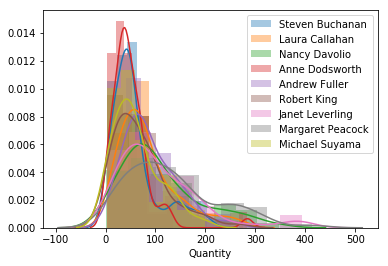

In [23]:
for seller in seller_df['Name'].unique():
    sns.distplot(seller_df['Quantity'][seller_df['Name'] == seller], label=seller)
    plt.legend()

There are concerns that the data may not be normally distributed.

### Hypothesis Tests
The fist thing we will do is run a KS test to see if the data is normally distributed. Next, we will determine if we need to run a one-way ANOVA or a K-W Test.

In [24]:
stats.kstest(seller_df['Quantity'][seller_df['Name'] == 'Michael Suyama'].values, 'norm')

KstestResult(statistic=0.9999683287581669, pvalue=0.0)

In [25]:
sellers = [seller_df['Quantity'][seller_df['Name'] == seller].values for seller in seller_df['Name'].unique()]
stats.kruskal(*sellers)

KruskalResult(statistic=79.14431613647092, pvalue=7.267197255615108e-14)

The KS test confirmed the data was not normally distributed and the KW test has a p-value smaller than our alpha of .05. Therefore, we reject the null hypothesis and accept that employees do have an impact on the quantity of items ordered.

## Experiment 4: Customer
The last experiment is to see if the customer makes a difference in the quantity of a product ordered.

**Null Hypothesis: The customer has no impact on the quantity of a product ordered.**

**Alternate Hypothesis: The customer does have an impact on the quantity of a product ordered.**

### Gather the Data

In [27]:
cur.execute("""
    Select CompanyName, ProductID, Sum(Quantity) as Quantity 
    FROM Employee
    Join [Order]
    ON [Order].EmployeeID = Employee.ID
    Join OrderDetail
    ON [Order].ID = OrderDetail.OrderID
    JOIN Customer
    ON [Order].CustomerID = Customer.ID
    Group BY CompanyName, ProductID
""")
buyer_df = pd.DataFrame(cur.fetchall())
buyer_df.columns = [x[0] for x in cur.description]
buyer_df.head()

,CompanyName,ProductId,Quantity
0,Alfreds Futterkiste,3,6
1,Alfreds Futterkiste,6,16
2,Alfreds Futterkiste,28,17
3,Alfreds Futterkiste,39,21
4,Alfreds Futterkiste,46,2


### Distribution Plot

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


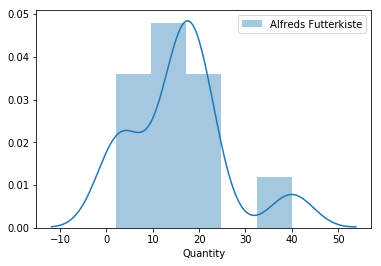

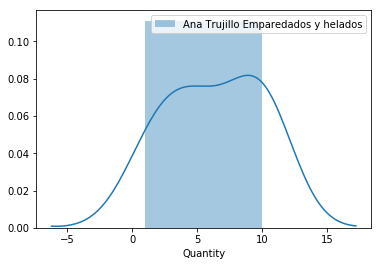

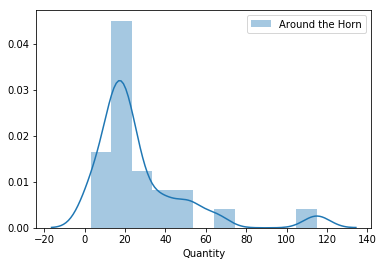

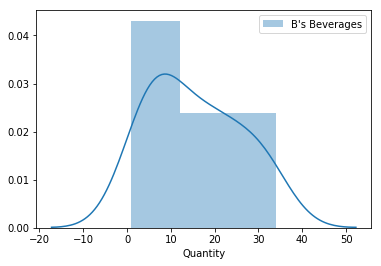

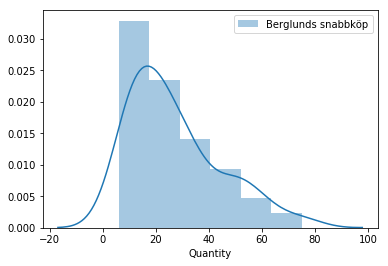

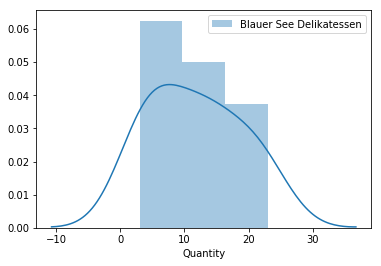

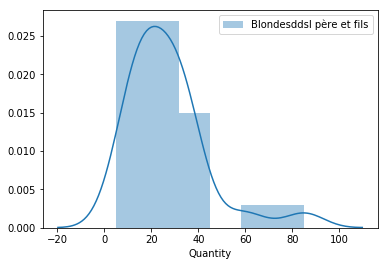

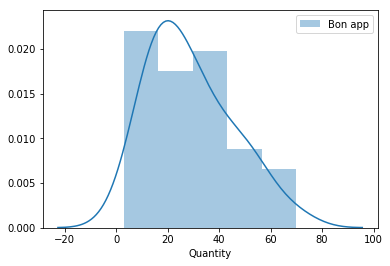

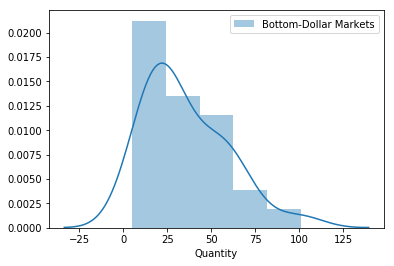

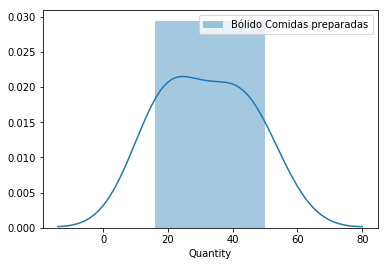

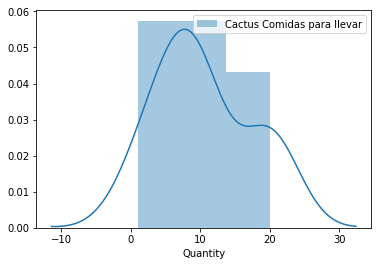

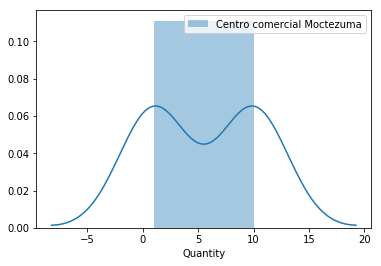

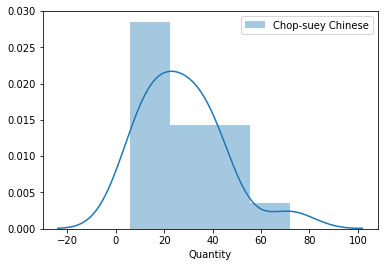

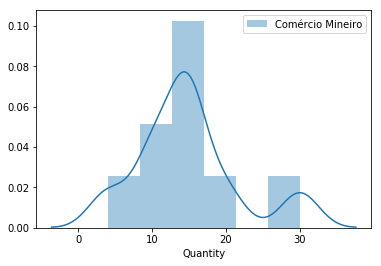

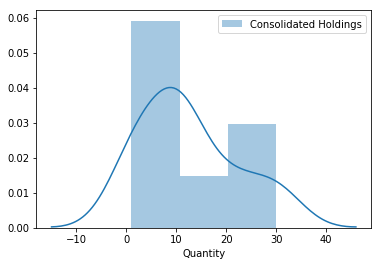

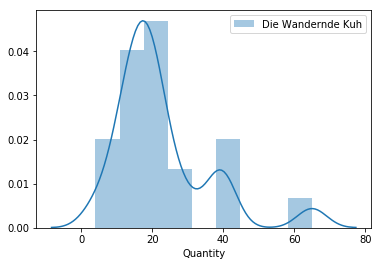

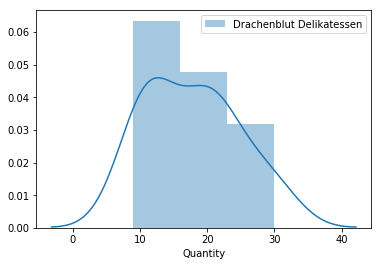

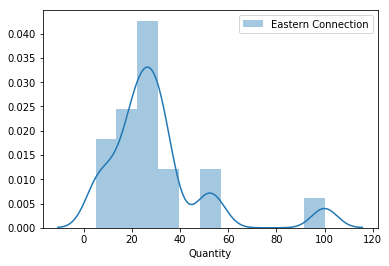

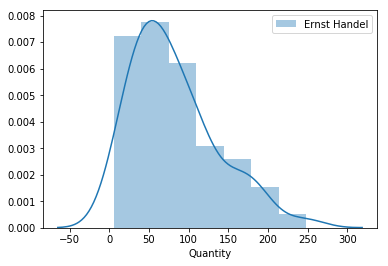

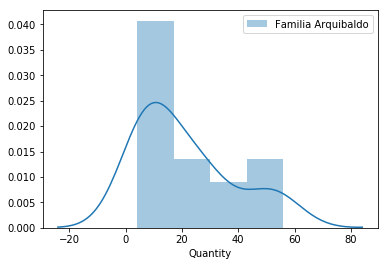

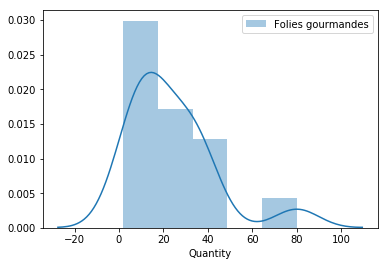

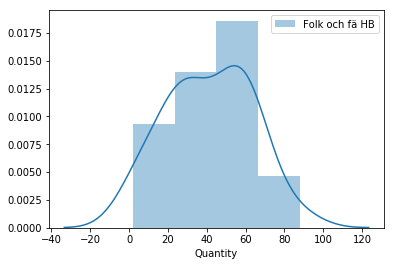

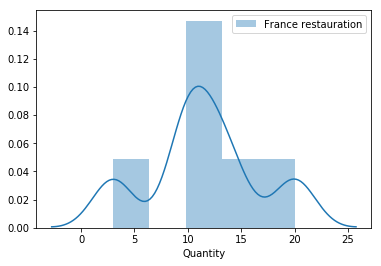

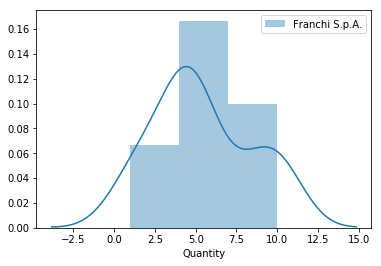

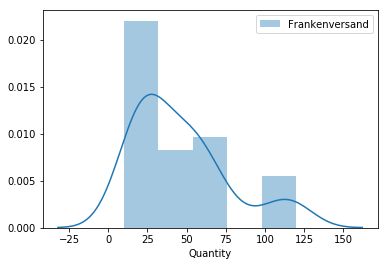

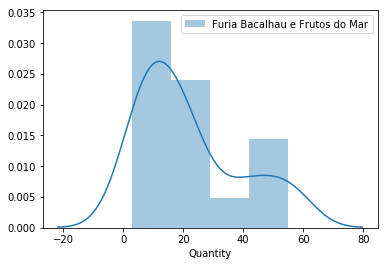

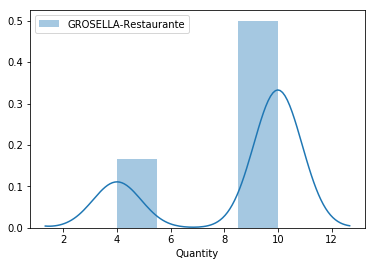

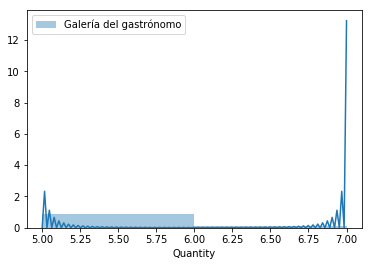

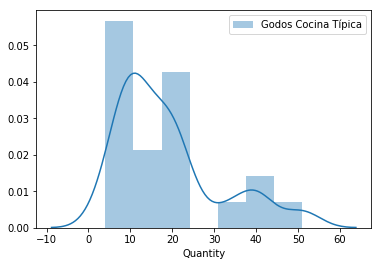

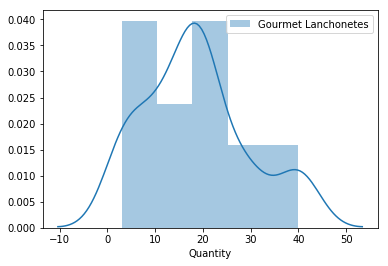

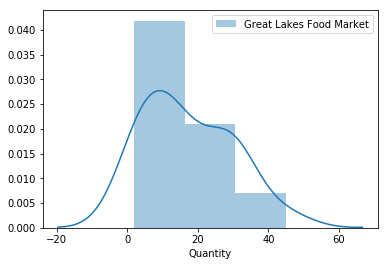

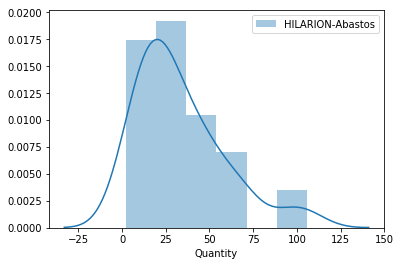

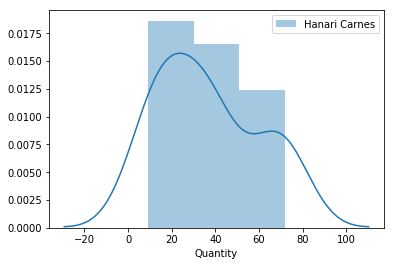

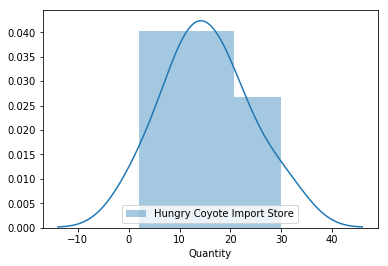

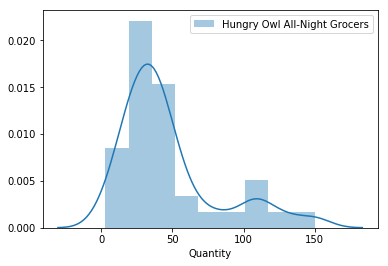

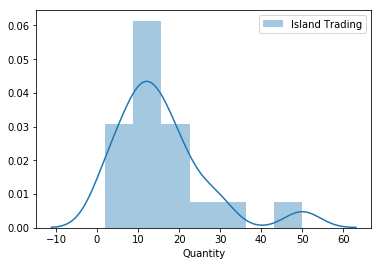

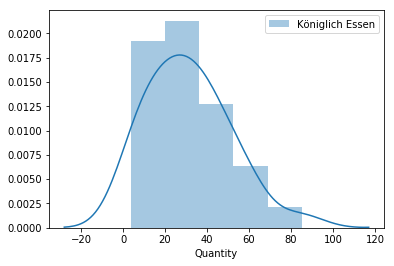

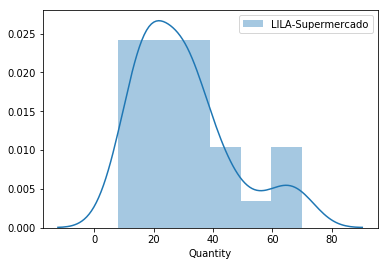

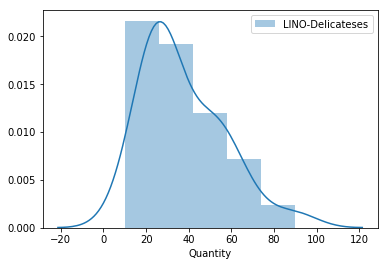

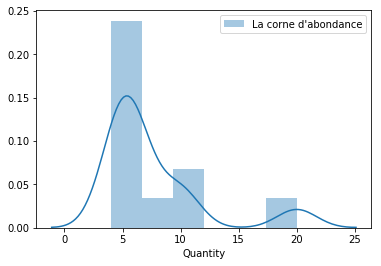

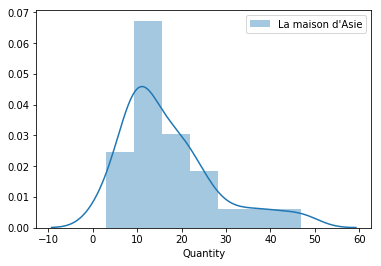

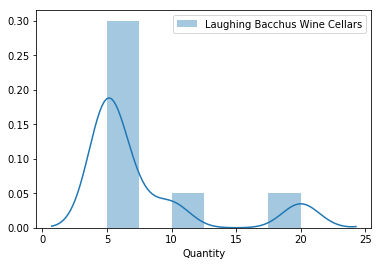

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


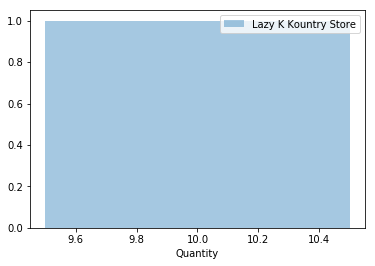

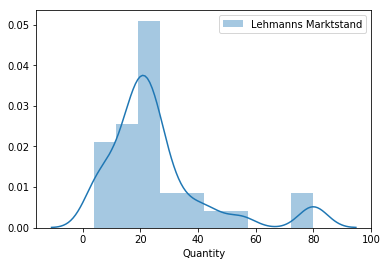

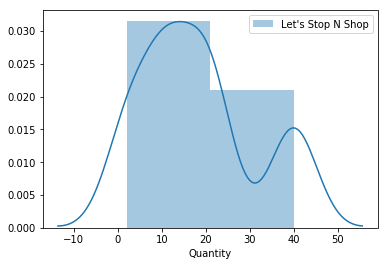

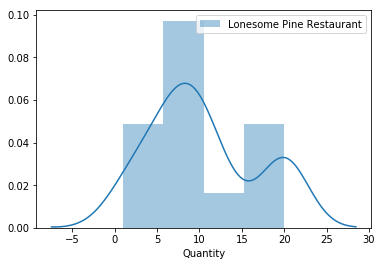

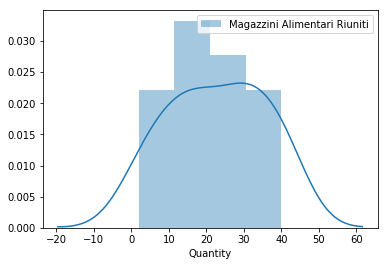

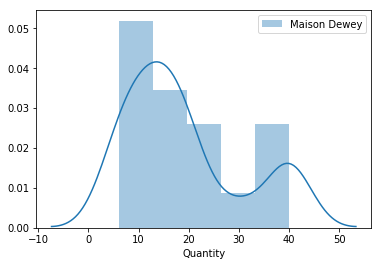

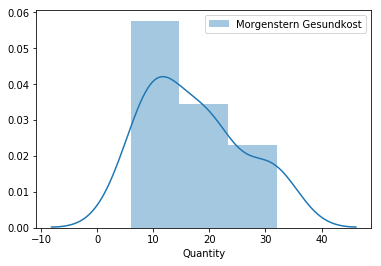

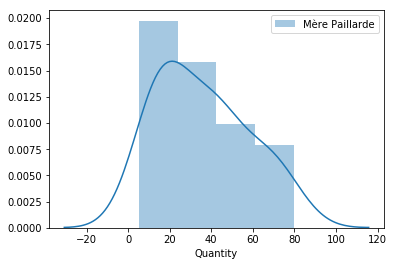

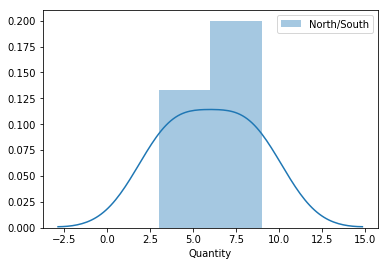

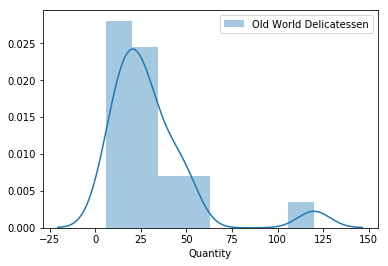

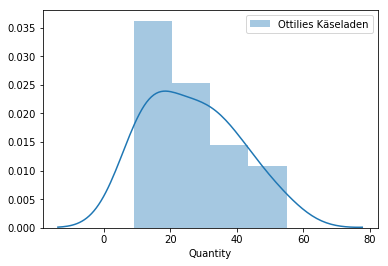

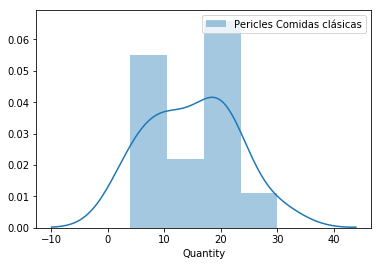

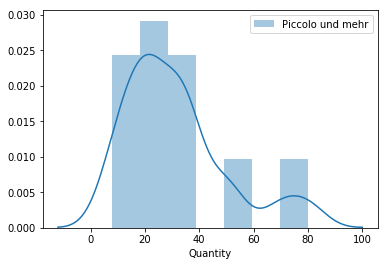

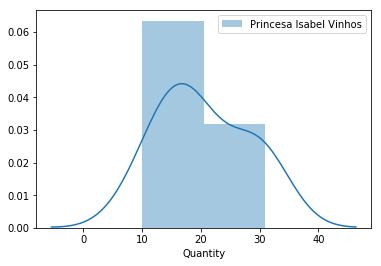

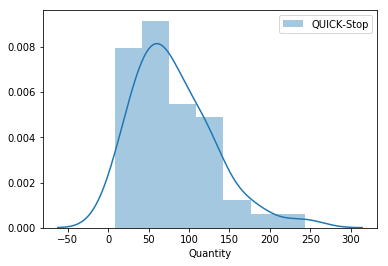

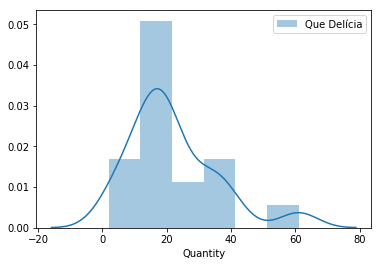

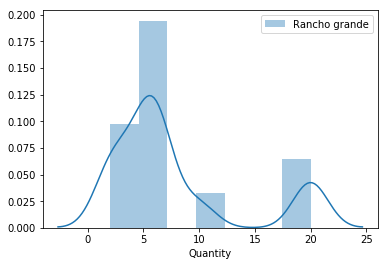

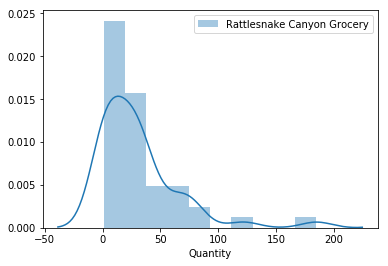

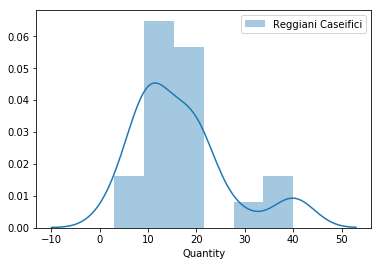

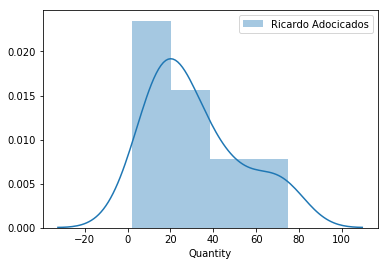

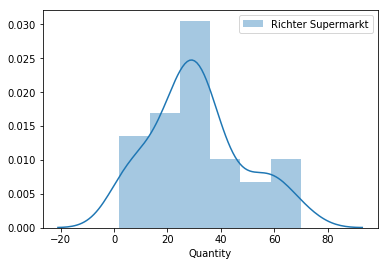

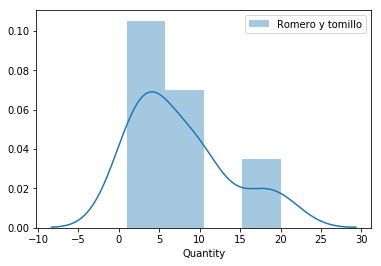

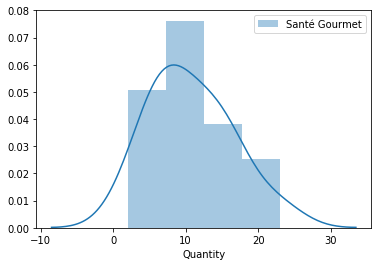

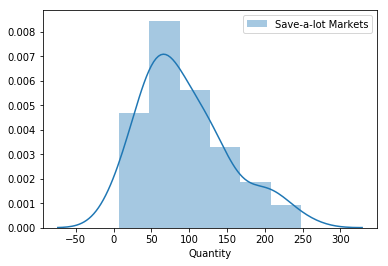

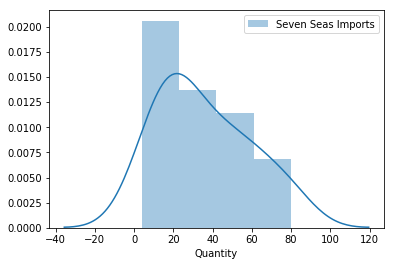

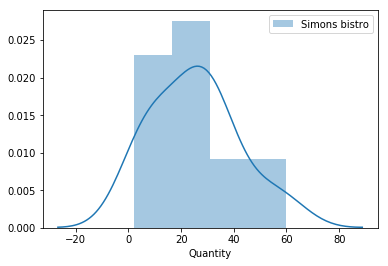

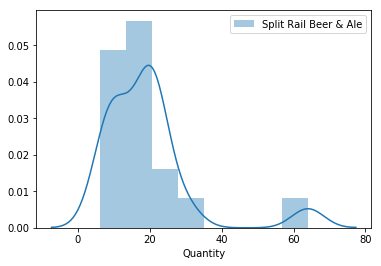

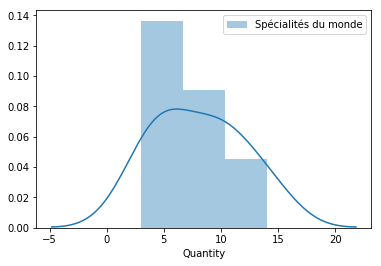

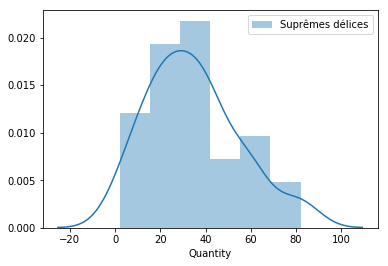

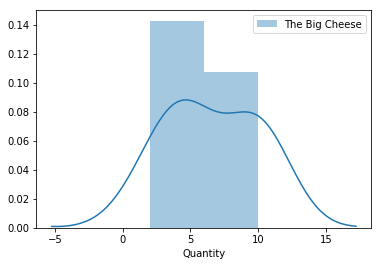

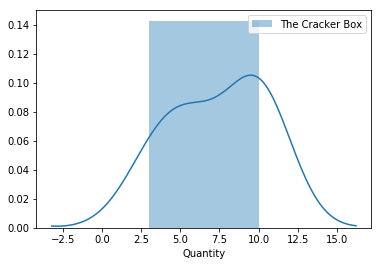

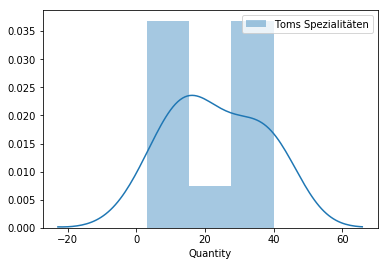

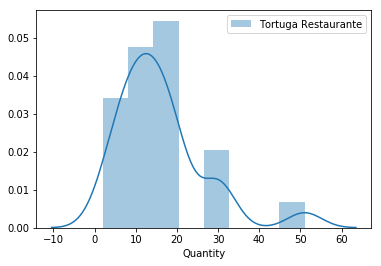

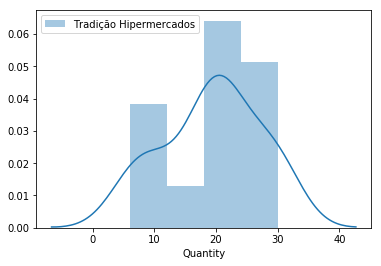

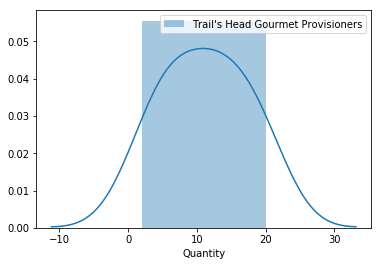

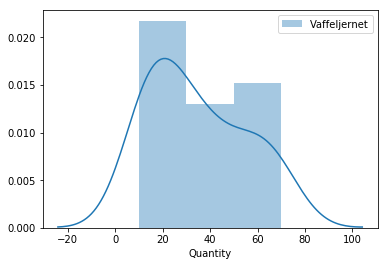

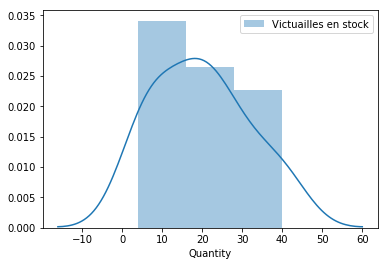

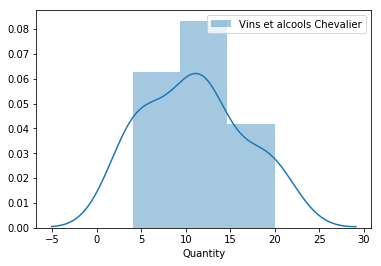

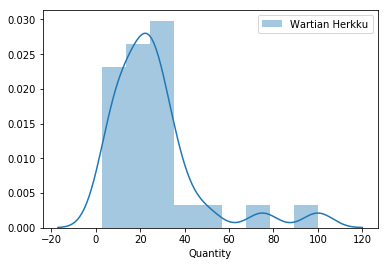

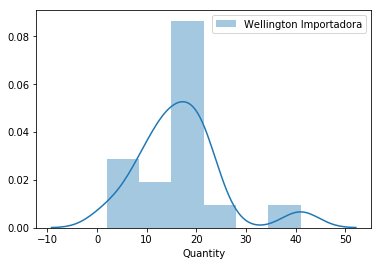

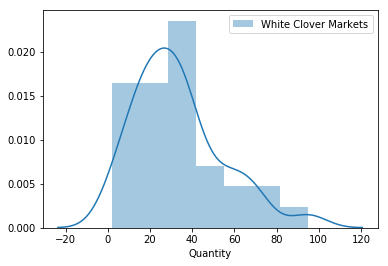

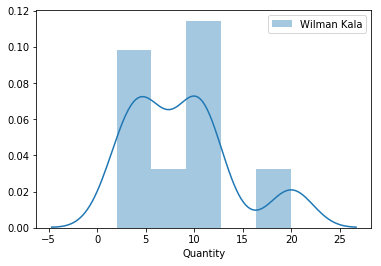

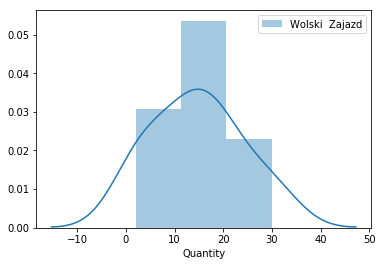

In [236]:
for buyer in buyer_df['CompanyName'].unique():
    sns.distplot(buyer_df['Quantity'][buyer_df['CompanyName'] == buyer], label=buyer)
    plt.legend()
    plt.show()

### Hypothesis Test

In [28]:
buyers = [buyer_df['Quantity'][buyer_df['CompanyName'] == buyer].values for buyer in buyer_df['CompanyName'].unique()]
stats.kruskal(*buyers)

KruskalResult(statistic=649.8997622236733, pvalue=2.4800369533692066e-88)

The K-W Test has a p-value smaller than our alpha of .05. Therefore, we reject the null hypothesis and accept that customers do have an impact on the quantity of an item ordered.